In [1]:
import pandas as pd 
import numpy as np
import os 
import re
import pickle
import json
import torch
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None

data_path = '/data/gusev/USERS/jpconnor/clinical_text_project/data/'
survival_data_path = data_path + 'survival_data/'

In [2]:
embedding_meta = pd.read_csv(data_path + 'full_IO_embeddings_metadata_v2.csv')
just_embeddings = np.load(open(data_path + 'full_IO_embeddings_as_array_v2.npy', 'rb'))
full_events_df = pd.read_csv(survival_data_path + 'full_irAE_survival_data.csv')

/tmp/ipykernel_257019/1169755534.py:1: DtypeWarning: Columns (2,4,7,8,9,11,12,13,14,22,23,25,29,32,33,36,37,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  embedding_meta = pd.read_csv(data_path + 'full_IO_embeddings_metadata_v2.csv')


## Basic EDA

In [3]:
# prep dataframes for plotting
num_px = len(full_events_df['PATIENT_ID'])

embedding_meta['COUNT'] = 1
per_px_notes_count = embedding_meta[['COUNT', 'DFCI_MRN', 'NOTE_TYPE']].groupby(['DFCI_MRN', 'NOTE_TYPE']).sum().reset_index()
embedding_meta.drop(columns=['COUNT'], inplace=True)

per_px_image_note_ct = per_px_notes_count.loc[per_px_notes_count['NOTE_TYPE'] == 'Imaging']
per_px_path_note_ct = per_px_notes_count.loc[per_px_notes_count['NOTE_TYPE'] == 'Pathology']
per_px_clinician_note_ct = per_px_notes_count.loc[per_px_notes_count['NOTE_TYPE'] == 'Clinician']

full_events_df['IMAGE_NOTE_COUNT'] = full_events_df['PATIENT_ID'].map(dict(zip(per_px_image_note_ct['DFCI_MRN'], per_px_image_note_ct['COUNT'])))
full_events_df['PATH_NOTE_COUNT'] = full_events_df['PATIENT_ID'].map(dict(zip(per_px_path_note_ct['DFCI_MRN'], per_px_path_note_ct['COUNT'])))
full_events_df['CLINICIAN_NOTE_COUNT'] = full_events_df['PATIENT_ID'].map(dict(zip(per_px_clinician_note_ct['DFCI_MRN'], per_px_clinician_note_ct['COUNT'])))

note_count_df = pd.DataFrame({'NUM_NOTES_PER_PX' : full_events_df['IMAGE_NOTE_COUNT'].tolist() + full_events_df['PATH_NOTE_COUNT'].tolist() + full_events_df['CLINICIAN_NOTE_COUNT'].tolist(),
                              'NOTE_TYPE' : ['Imaging' for _ in range(num_px)] + ['Pathology' for _ in range(num_px)] + ['Clinician' for _ in range(num_px)]})

unique_mrns = embedding_meta['DFCI_MRN'].unique()

record_len_df = pd.DataFrame({'DFCI_MRN' : unique_mrns, 
                              'Days_Pre_IO' : [-np.min(embedding_meta.loc[embedding_meta['DFCI_MRN'] == mrn, 'NOTE_TIME_REL_IO_START']) for mrn in unique_mrns],
                              'Days_Post_IO' : [np.max(embedding_meta.loc[embedding_meta['DFCI_MRN'] == mrn, 'NOTE_TIME_REL_IO_START']) for mrn in unique_mrns]})

[Text(0.5, 1.0, 'Length of Clinical Record Prior to Treatment')]

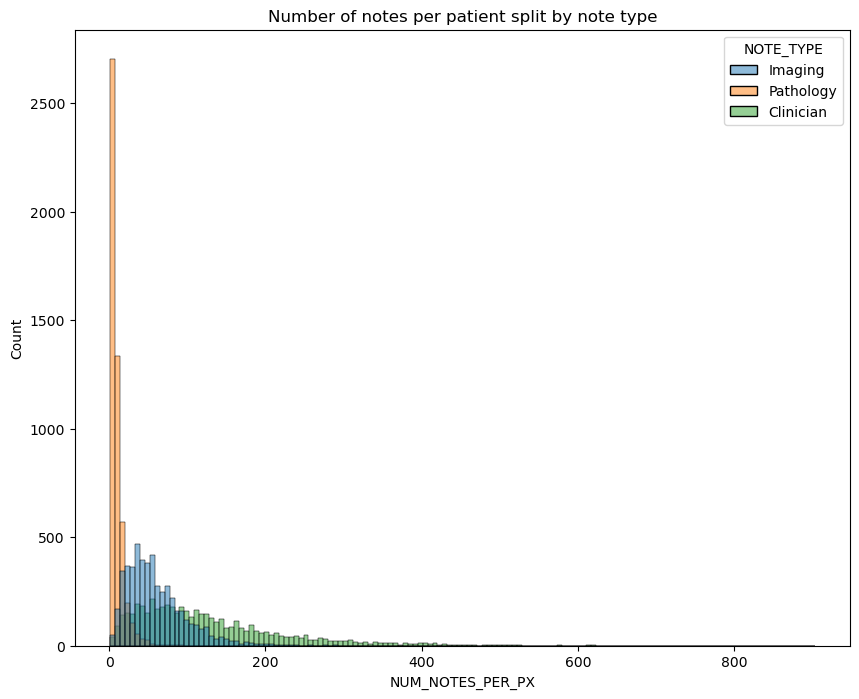

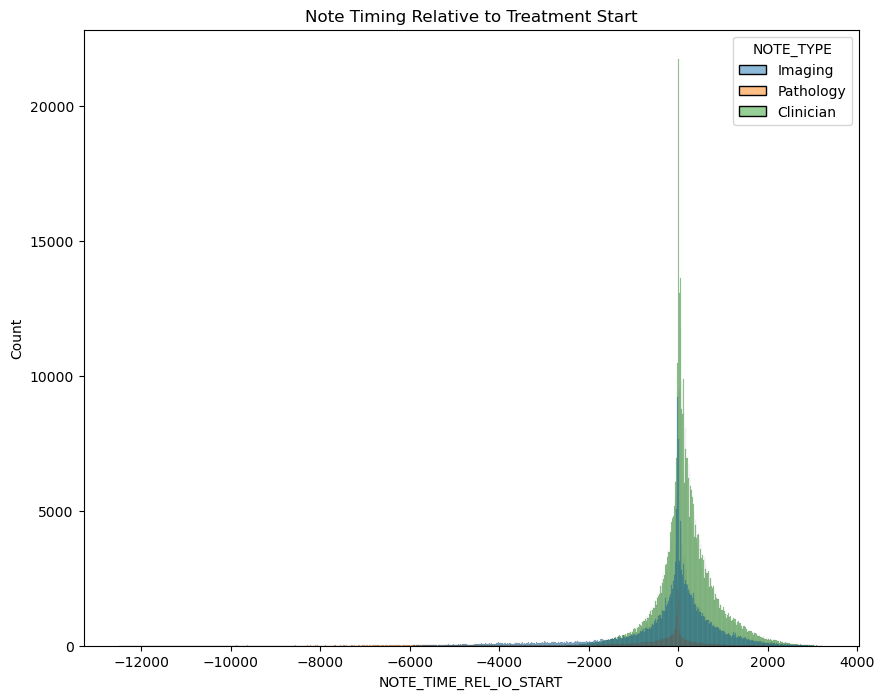

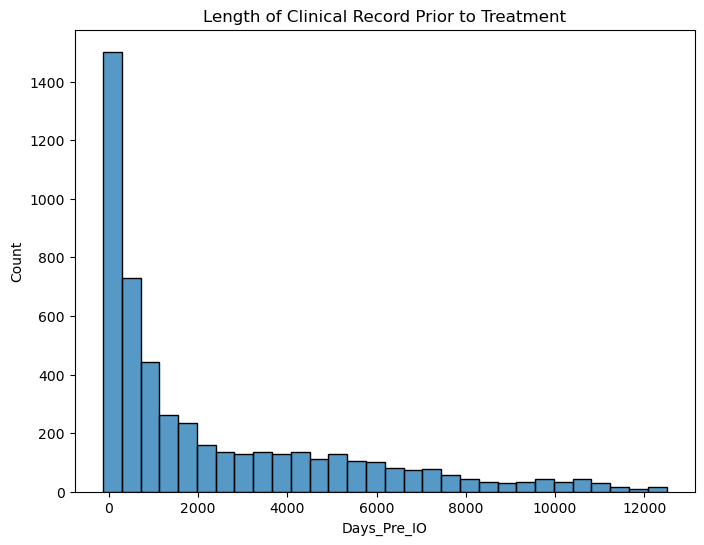

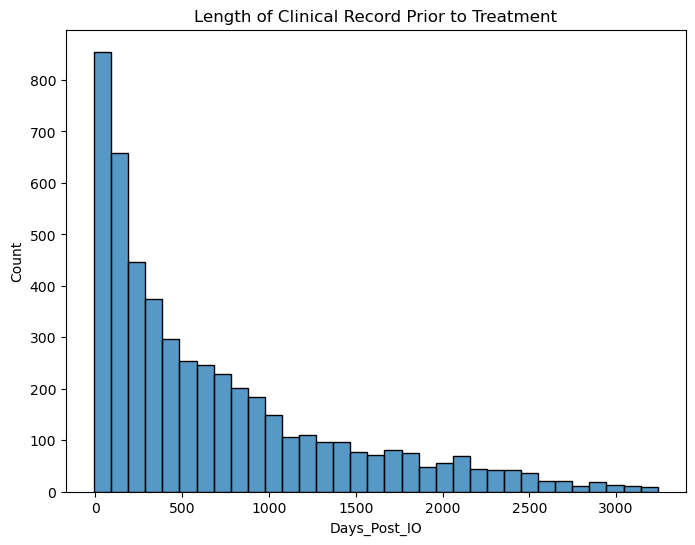

In [4]:
plt.figure(figsize=(10,8))
sns.histplot(note_count_df, x='NUM_NOTES_PER_PX', hue='NOTE_TYPE').set(title='Number of notes per patient split by note type')

plt.figure(figsize=(10,8))
sns.histplot(embedding_meta, x='NOTE_TIME_REL_IO_START', hue='NOTE_TYPE').set(title='Note Timing Relative to Treatment Start')

plt.figure(figsize=(8,6))
sns.histplot(record_len_df, x='Days_Pre_IO').set(title='Length of Clinical Record Prior to Treatment')

plt.figure(figsize=(8,6))
sns.histplot(record_len_df, x='Days_Post_IO').set(title='Length of Clinical Record Prior to Treatment')

## Embedding PCA

In [5]:
embedding_pca = PCA().fit(just_embeddings[embedding_meta['EMBEDDING_INDEX'],:])

transformed_embeddings = embedding_pca.transform(just_embeddings[embedding_meta['EMBEDDING_INDEX'],:])

embedding_meta['PC_1'] = transformed_embeddings[:,0]
embedding_meta['PC_2'] = transformed_embeddings[:,1]

In [6]:
embedding_meta['NOTE_YEAR'] = embedding_meta['NOTE_DATETIME'].apply(lambda x : int(re.split('-', x)[0]))

### PCs across note types

[Text(0.5, 1.0, "PCA of Embeddings by Patient's Event")]

/data/gusev/USERS/jpconnor/conda/envs/clinical_notes_llm_project/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


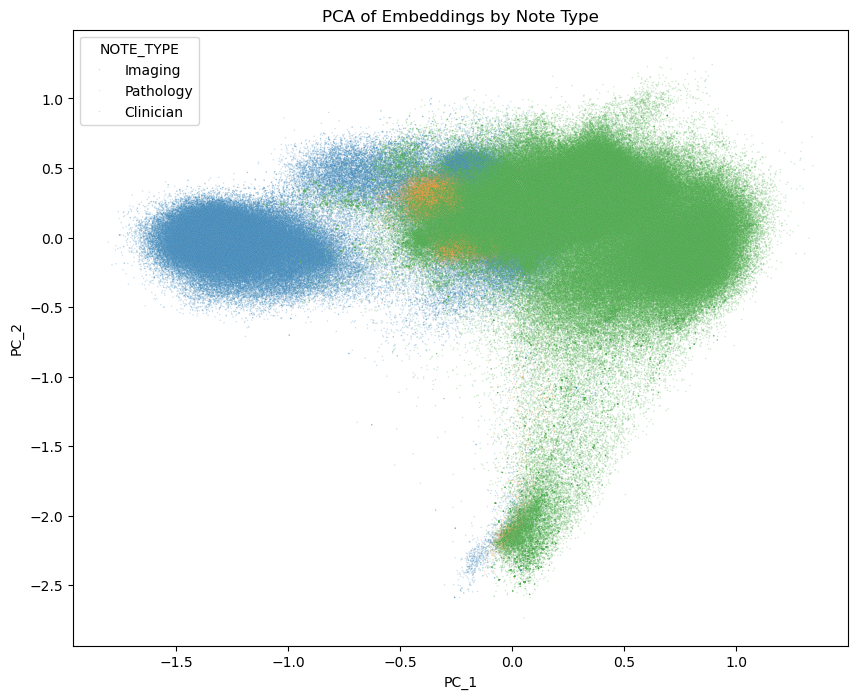

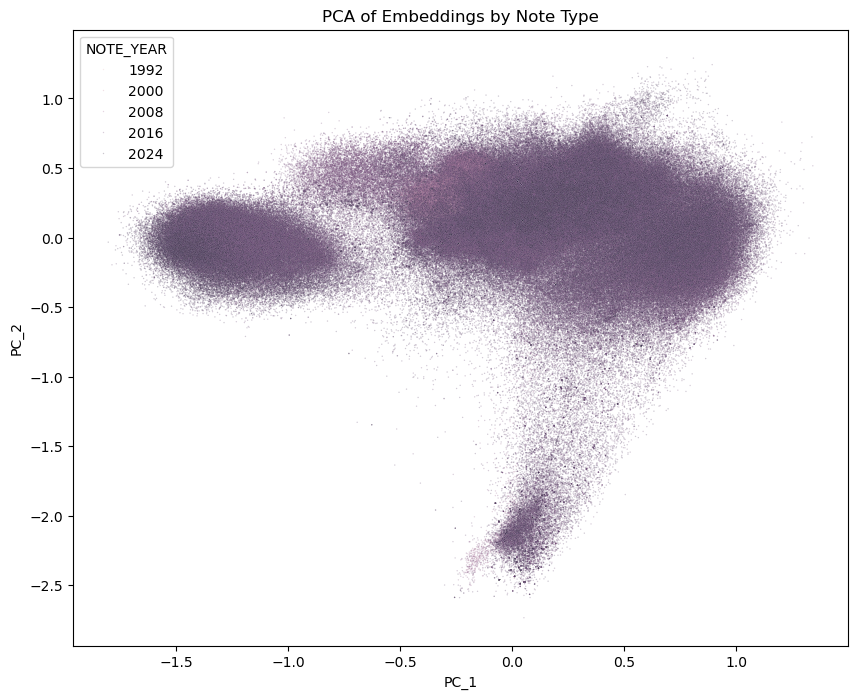

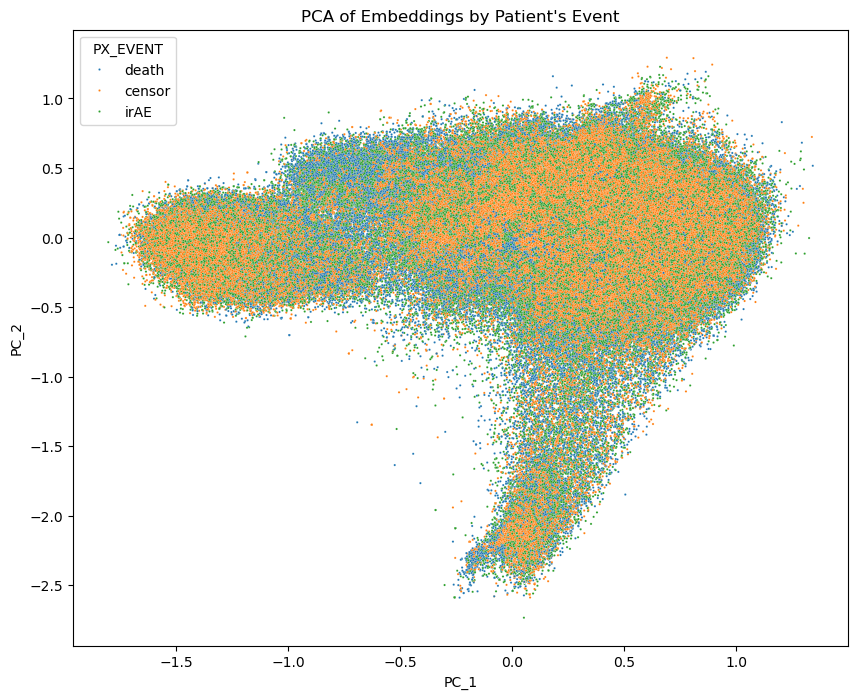

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(embedding_meta, x='PC_1', y='PC_2', s=1, alpha=0.25, hue='NOTE_TYPE').set(title='PCA of Embeddings by Note Type')

plt.figure(figsize=(10, 8))
sns.scatterplot(embedding_meta, x='PC_1', y='PC_2', s=1, alpha=0.25, hue='NOTE_YEAR').set(title='PCA of Embeddings by Note Type')

plt.figure(figsize=(10,8))
sns.scatterplot(embedding_meta, x='PC_1', y='PC_2', s=2.5, hue='PX_EVENT').set(title='PCA of Embeddings by Patient\'s Event')

# plt.figure(figsize=(10,8))
# sns.scatterplot(embedding_meta, x='PC_1', y='PC_2', s=2.5, hue='TIME_REL_IO_START_CAT').set(title='PCA of Embeddings by Note Timing Relative to Treatment Start')

### PCs just clinician

In [8]:
clinician_notes_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Clinician'].copy()

clinician_pca = PCA(n_components=2).fit(just_embeddings[clinician_notes_meta['EMBEDDING_INDEX'],:])
transformed_clinician_embeddings = clinician_pca.transform(just_embeddings[clinician_notes_meta['EMBEDDING_INDEX'],:])

clinician_notes_meta['CLINICIAN_PC_1'] = transformed_clinician_embeddings[:,0]
clinician_notes_meta['CLINICIAN_PC_2'] = transformed_clinician_embeddings[:,1]

[Text(0.5, 1.0, 'PCA of Clinician Notes by Note Timing Relative to Treatment Start')]

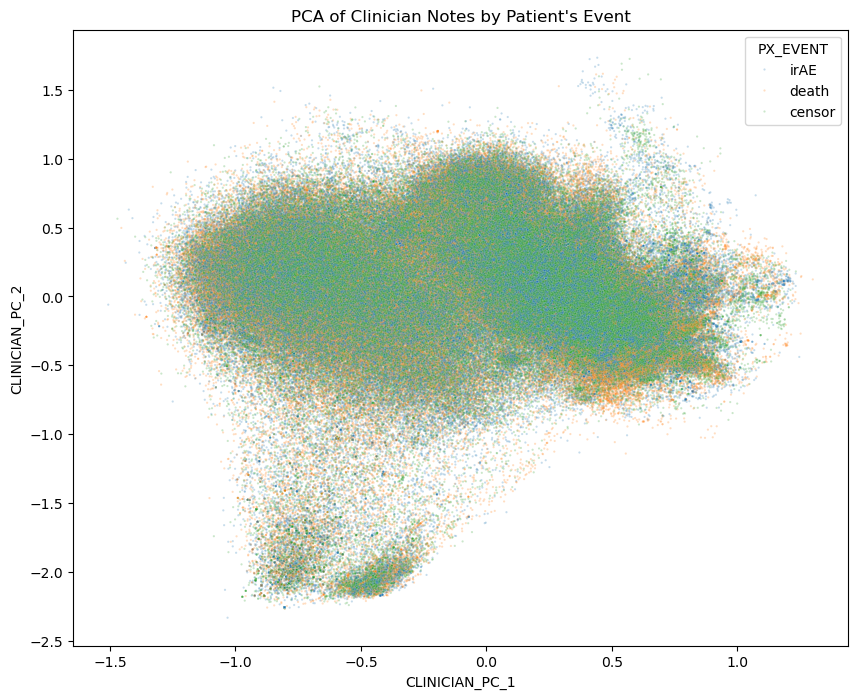

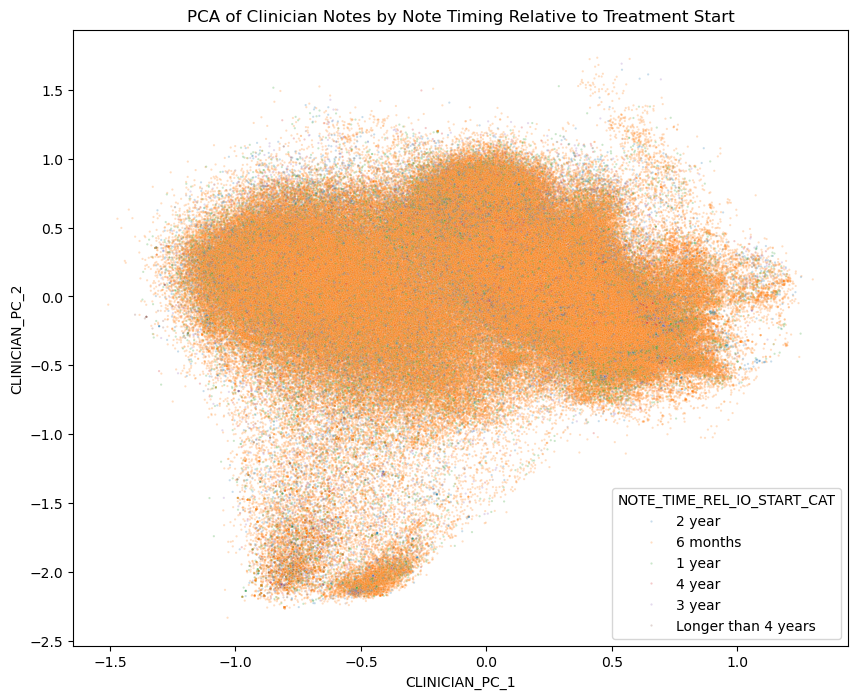

In [9]:
plt.figure(figsize=(10,8))
sns.scatterplot(clinician_notes_meta, x='CLINICIAN_PC_1', y='CLINICIAN_PC_2', s=2.5, alpha=0.25, hue='PX_EVENT').set(title='PCA of Clinician Notes by Patient\'s Event')

plt.figure(figsize=(10,8))
sns.scatterplot(clinician_notes_meta, x='CLINICIAN_PC_1', y='CLINICIAN_PC_2', s=2.5, alpha=0.25, hue='NOTE_TIME_REL_IO_START_CAT').set(title='PCA of Clinician Notes by Note Timing Relative to Treatment Start')

### PCs just imaging

In [10]:
imaging_notes_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Imaging'].copy()

imaging_pca = PCA(n_components=2).fit(just_embeddings[imaging_notes_meta['EMBEDDING_INDEX'],:])
transformed_imaging_embeddings = imaging_pca.transform(just_embeddings[imaging_notes_meta['EMBEDDING_INDEX'],:])

imaging_notes_meta['IMAGE_PC_1'] = transformed_imaging_embeddings[:,0]
imaging_notes_meta['IMAGE_PC_2'] = transformed_imaging_embeddings[:,1]

[Text(0.5, 1.0, 'PCA of Imaging Notes by Note Timing Relative to Treatment Start')]

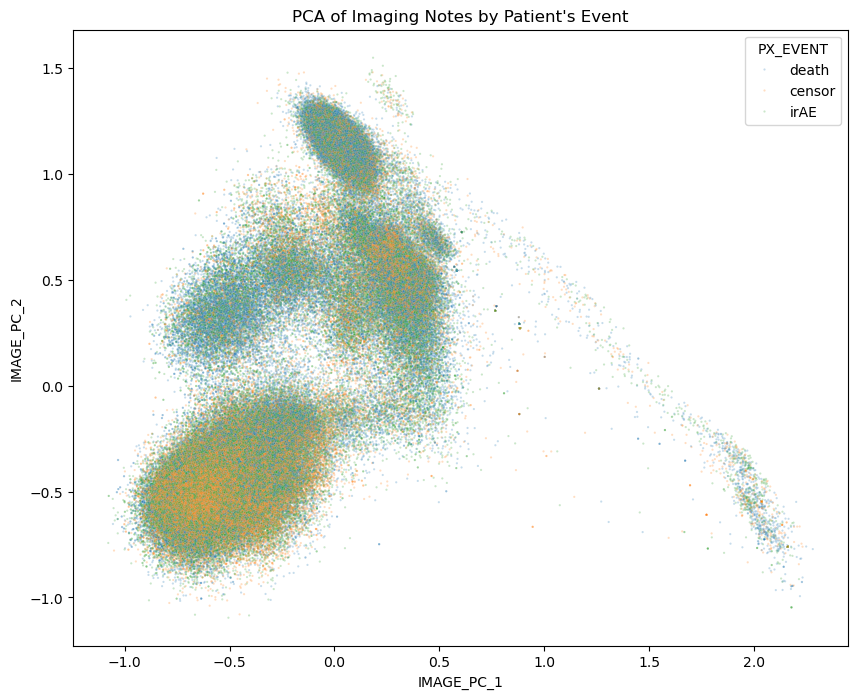

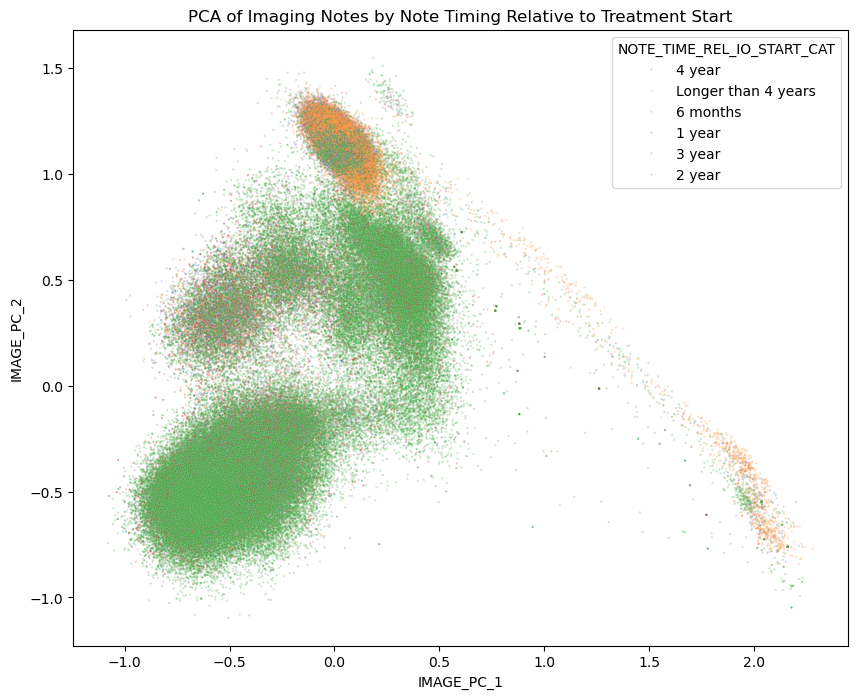

In [11]:
plt.figure(figsize=(10,8))
sns.scatterplot(imaging_notes_meta, x='IMAGE_PC_1', y='IMAGE_PC_2', s=2.5, alpha=0.25, hue='PX_EVENT').set(title='PCA of Imaging Notes by Patient\'s Event')

plt.figure(figsize=(10,8))
sns.scatterplot(imaging_notes_meta, x='IMAGE_PC_1', y='IMAGE_PC_2', s=2.5, alpha=0.25, hue='NOTE_TIME_REL_IO_START_CAT').set(title='PCA of Imaging Notes by Note Timing Relative to Treatment Start')

### PCs just pathology

In [12]:
path_notes_meta = embedding_meta.loc[embedding_meta['NOTE_TYPE'] == 'Pathology'].copy()

path_pca = PCA(n_components=2).fit(just_embeddings[path_notes_meta['EMBEDDING_INDEX'],:])
transformed_path_embeddings = path_pca.transform(just_embeddings[path_notes_meta['EMBEDDING_INDEX'],:])

path_notes_meta['PATHOLOGY_PC_1'] = transformed_path_embeddings[:,0]
path_notes_meta['PATHOLOGY_PC_2'] = transformed_path_embeddings[:,1]

[Text(0.5, 1.0, 'PCA of Pathology Notes by Note Timing Relative to Treatment Start')]

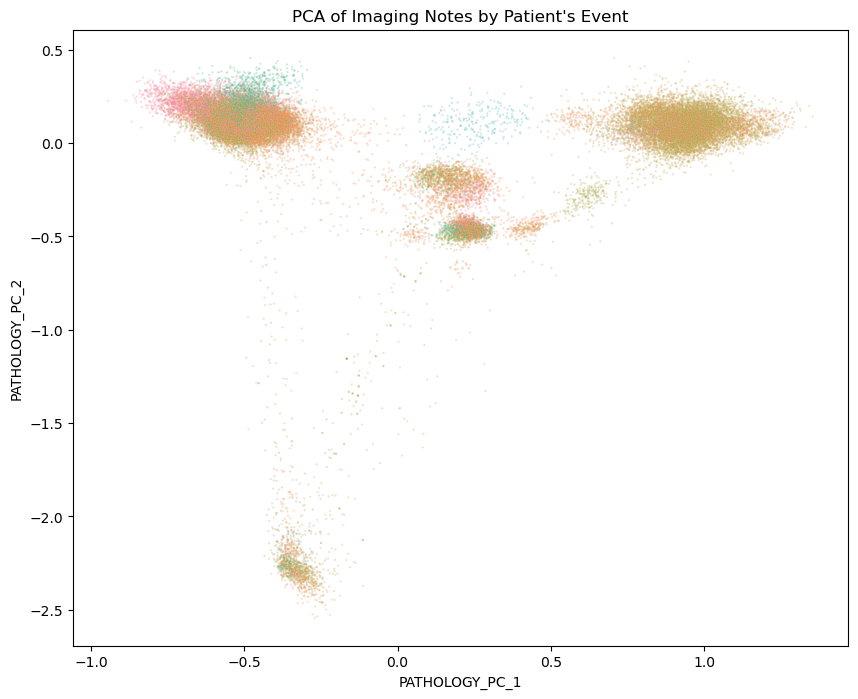

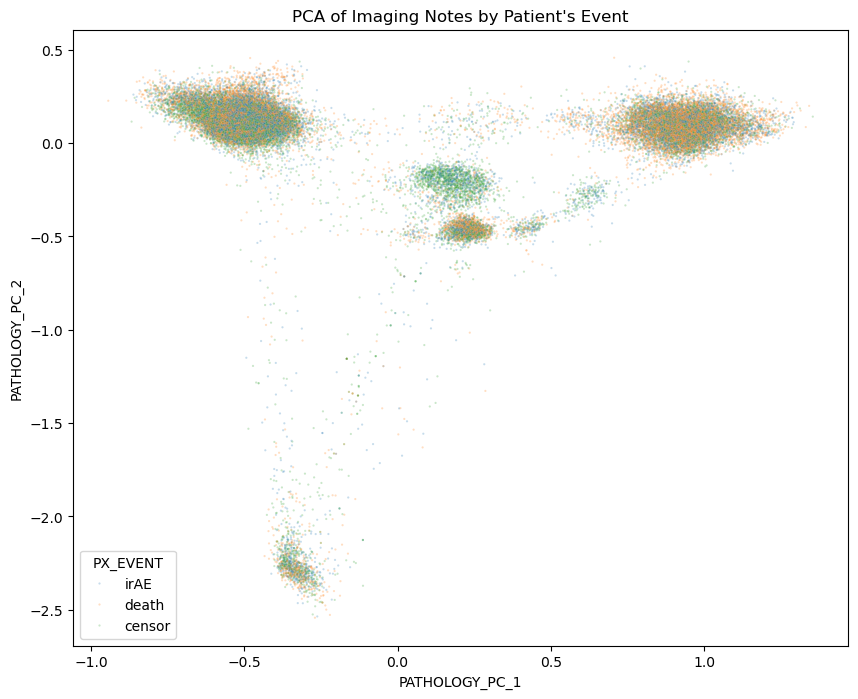

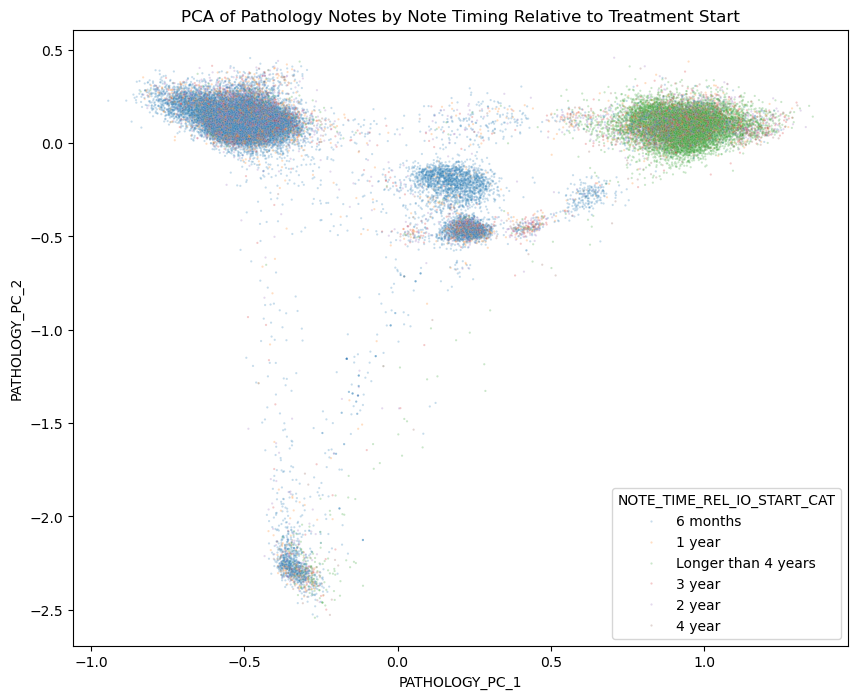

In [13]:
plt.figure(figsize=(10,8))
sns.scatterplot(path_notes_meta, x='PATHOLOGY_PC_1', y='PATHOLOGY_PC_2', s=2.5, alpha=0.25, hue='PROC_DESC', legend=False).set(title='PCA of Imaging Notes by Patient\'s Event')

plt.figure(figsize=(10,8))
sns.scatterplot(path_notes_meta, x='PATHOLOGY_PC_1', y='PATHOLOGY_PC_2', s=2.5, alpha=0.25, hue='PX_EVENT').set(title='PCA of Imaging Notes by Patient\'s Event')

plt.figure(figsize=(10,8))
sns.scatterplot(path_notes_meta, x='PATHOLOGY_PC_1', y='PATHOLOGY_PC_2', s=2.5, alpha=0.25, hue='NOTE_TIME_REL_IO_START_CAT').set(title='PCA of Pathology Notes by Note Timing Relative to Treatment Start')